In [3]:
#import findspark, pyspark
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
from datetime import datetime
from functools import reduce
from pyspark.sql.functions import col

#sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

file_attack = 'gtd_14to17_0718dist'
file_airport = 'airports-extended'
file_largest_airport = 'largest-global-airports-passenger-traffic'
file_passengers = 'avia_par_be'

# Fetch Data

In [4]:
#data_path = 'D:/DataMining/taba/'
data_path = '../Datasets/'

attack_data = sc.textFile(data_path + 'gtd-data/' + file_attack + '.csv')
airport_data = sc.textFile(data_path + file_airport + '.csv')
passenger_data_brussels = sc.textFile(data_path + file_passengers + '.csv')

# Prepare Attack Data

In [5]:
# Define columns for dataframe
new_columns = attack_data.first()
new_columns = new_columns.split(";")
attack_data = attack_data.filter(lambda l: l != new_columns)
df_terror_data = attack_data.map(lambda x: x.split(';')).toDF()
old_columns = df_terror_data.schema.names

In [6]:
# apply new column names
df_terror_data = reduce(lambda data, idx: data.withColumnRenamed(old_columns[idx], new_columns[idx]), range(len(old_columns)), df_terror_data)

# Query Attack Data

In [7]:
#query_result = df_terror_data.filter(col("country_txt") == "Belgium").select('iyear', 'imonth', 'iday','country_txt', 'summary')
query_result = df_terror_data.filter(col("country_txt") == "Belgium").select('iyear', 'imonth', 'iday','country_txt', 'summary', 'city', 'nkill')


## Data waar enkel data instaat die impact zou hebben op reizigers 2016

In [8]:
query_brussel= query_result.filter(col("iyear") == "2016").select('iyear', 'imonth', 'iday','country_txt', 'summary', 'city', 'nkill')
query_brussel = query_brussel.filter(col("nkill") > 0)
query_brussel.show()

+-----+------+----+-----------+--------------------+---------+-----+
|iyear|imonth|iday|country_txt|             summary|     city|nkill|
+-----+------+----+-----------+--------------------+---------+-----+
| 2016|     3|  22|    Belgium|03/22/2016: Two s...| Zaventem|   18|
| 2016|     3|  22|    Belgium|03/22/2016: A sui...| Brussels|   17|
| 2016|     8|   6|    Belgium|08/06/2016: An as...|Charleroi|    1|
+-----+------+----+-----------+--------------------+---------+-----+



# Prepare airport data

In [9]:
fields = []
fields.append(StructField('airport_id', IntegerType(), True)) 
fields.append(StructField('airport_name', StringType(), True))
fields.append(StructField('city', StringType(), True))
fields.append(StructField('country', StringType(), True))
fields.append(StructField('IATA', StringType(), True)) # kind of airport identifier
fields.append(StructField('ICAO', StringType(), True)) # different kind of airport identifier
fields.append(StructField('latitude', FloatType(), True))
fields.append(StructField('longitude', FloatType(), True))
fields.append(StructField('unknown1', IntegerType(), True))
fields.append(StructField('unknown2', StringType(), True))
fields.append(StructField('unknown3', StringType(), True))
fields.append(StructField('continent_city', StringType(), True))
fields.append(StructField('idk_column', StringType(), True))
fields.append(StructField('source', StringType(), True))
schema = StructType(fields)

clean_data = (airport_data
              .map(lambda line: line.split(';'))
              .map(lambda line: [int(line[0]),line[1],line[2],line[3],line[4],line[5],float(line[6]),float(line[7]),int(line[8]),line[9],line[10],line[11],line[12],line[13]])
             )
df_airport_data = sqlContext.createDataFrame(clean_data, schema)

# Query airport data

In [10]:
(df_airport_data
 .select(df_airport_data.airport_name, df_airport_data.city,df_airport_data.continent_city)
 .filter(df_airport_data.continent_city == 'Europe/Brussels')
 .show(df_airport_data.count(),False))

+--------------------------------------+-----------------+---------------+
|airport_name                          |city             |continent_city |
+--------------------------------------+-----------------+---------------+
|Antwerp International Airport (Deurne)|Antwerp          |Europe/Brussels|
|Beauvechain Air Base                  |Beauvechain      |Europe/Brussels|
|Kleine Brogel Air Base                |Kleine Brogel    |Europe/Brussels|
|Brussels Airport                      |Brussels         |Europe/Brussels|
|Jehonville Air Base                   |Bertrix          |Europe/Brussels|
|Brussels South Charleroi Airport      |Charleroi        |Europe/Brussels|
|Chièvres Air Base                     |Chievres         |Europe/Brussels|
|Koksijde Air Base                     |Koksijde         |Europe/Brussels|
|Florennes Air Base                    |Florennes        |Europe/Brussels|
|Wevelgem Airport                      |Kortrijk-vevelgem|Europe/Brussels|
|Liège Airport           

# Prepare passenger data

## Cleaning

In [11]:
international_passengers_file =  'international-passengers-'
international_passengers_2013 = sc.textFile(data_path + international_passengers_file + '2013' + '.csv')
international_passengers_2014 = sc.textFile(data_path + international_passengers_file + '2014' + '.csv')

total_passengers_file = 'total-passengers-'
total_passengers_2013 = sc.textFile(data_path + total_passengers_file + '2013' + '.csv')
total_passengers_2014 = sc.textFile(data_path + total_passengers_file + '2014' + '.csv')

all_passenger_datasets_except2015 = [international_passengers_2013,international_passengers_2014,total_passengers_2013, total_passengers_2014]

counter = sc.accumulator(0)
def clean_passenger_data(rdd):
    global counter
    
    header = rdd.first()
    rdd = rdd.filter(lambda l: l != header)
    rdd = rdd.map(lambda l: l.split(";"))

    new_columns = rdd.map(lambda l: l[3].split("/"))

    rdd = rdd.map(lambda l: l[0:3] + l[4:])

    rdd = rdd.zip(new_columns)

    rdd = rdd.map(lambda l: l[0] + l[1])
    
    all_passenger_datasets_except2015[counter.value] = rdd
    
    counter +=  1
    
for dataset in all_passenger_datasets_except2015:
    clean_passenger_data(dataset)
    
print(all_passenger_datasets_except2015[0].take(2))

[['1', 'London Heathrow Airport', 'Hillingdon, Greater London, United Kingdom', '66689466', '4%', 'LHR', 'EGLL'], ['2', 'Dubai International Airport', 'Garhoud, Dubai, United Arab Emirates', '65872250', '15%', 'DXB', 'OMDB']]


## creating dataframe

### make the dataframes for the other datasets

In [12]:
fields = []
fields.append(StructField('rank', StringType(), True))
fields.append(StructField('airport_name', StringType(), True))
fields.append(StructField('location', StringType(), True))
fields.append(StructField('total_passengers', StringType(), True))
fields.append(StructField('change', StringType(), True))
fields.append(StructField('IATA', StringType(), True))
fields.append(StructField('ICAO', StringType(), True))
schema_passengers_data = StructType(fields)


df_international_passengers_2013 = sqlContext.createDataFrame(all_passenger_datasets_except2015[0], schema_passengers_data)
df_international_passengers_2014 = sqlContext.createDataFrame(all_passenger_datasets_except2015[1], schema_passengers_data)
df_total_passengers_2013 = sqlContext.createDataFrame(all_passenger_datasets_except2015[2], schema_passengers_data)
df_total_passengers_2014 = sqlContext.createDataFrame(all_passenger_datasets_except2015[3], schema_passengers_data)

datasets = [df_international_passengers_2013,df_international_passengers_2014,df_total_passengers_2013,df_total_passengers_2014]
for df in datasets:
    df.show(2)
    print("+++++++++++++++++++++++++++++++++")
    print()

+----+--------------------+--------------------+----------------+------+----+----+
|rank|        airport_name|            location|total_passengers|change|IATA|ICAO|
+----+--------------------+--------------------+----------------+------+----+----+
|   1|London Heathrow A...|Hillingdon, Great...|        66689466|    4%| LHR|EGLL|
|   2|Dubai Internation...|Garhoud, Dubai, U...|        65872250|   15%| DXB|OMDB|
+----+--------------------+--------------------+----------------+------+----+----+
only showing top 2 rows

+++++++++++++++++++++++++++++++++

+----+--------------------+--------------------+----------------+------+----+----+
|rank|        airport_name|            location|total_passengers|change|IATA|ICAO|
+----+--------------------+--------------------+----------------+------+----+----+
|   1|Dubai Internation...|Garhoud, Dubai, U...|        69954392|  6.2%| DXB|OMDB|
|   2|London Heathrow A...|Hillingdon, Great...|        68091095|  1.9%| LHR|EGLL|
+----+--------------------+

### fix the data from 2015 missing ICAO column

In [13]:
fields = []
fields.append(StructField('rank', StringType(), True))
fields.append(StructField('airport_name', StringType(), True))
fields.append(StructField('location', StringType(), True))
fields.append(StructField('country', StringType(), True))
fields.append(StructField('total_passengers', StringType(), True))
fields.append(StructField('change', StringType(), True))
fields.append(StructField('IATA', StringType(), True))
schema_total_passengers_2015 = StructType(fields)

fields = []
fields.append(StructField('rank', StringType(), True))
fields.append(StructField('airport_name', StringType(), True))
fields.append(StructField('location', StringType(), True))
fields.append(StructField('total_passengers', StringType(), True))
fields.append(StructField('change', StringType(), True))
fields.append(StructField('IATA', StringType(), True))
schema_international_passengers_2015 = StructType(fields)

In [14]:
total_passengers_2015 = sc.textFile(data_path + total_passengers_file + '2015' + '.csv')
international_passengers_2015 = sc.textFile(data_path + international_passengers_file + '2015' + '.csv')


# remove header
header = total_passengers_2015.first()
total_passengers_2015 = total_passengers_2015.filter(lambda l: l != header)
# create dataframe
df_total_passengers_2015 = sqlContext.createDataFrame(total_passengers_2015.map(lambda l: l.split(";")),schema_total_passengers_2015)
# add missing column by join using previous data (df_airport_data)
df_total_passengers_2015 = df_total_passengers_2015.join(df_airport_data.select(df_airport_data.IATA, df_airport_data.ICAO),"IATA")

# repeat for second dataset from 2015
international_passengers_2015 = sc.textFile(data_path + international_passengers_file + '2015' + '.csv')
header = international_passengers_2015.first()
international_passengers_2015 = international_passengers_2015.filter(lambda l: l != header)
temp = international_passengers_2015.map(lambda l: l.split(";"))
df_international_passengers_2015 = sqlContext.createDataFrame(international_passengers_2015.map(lambda l: l.split(";")),schema_international_passengers_2015)
df_international_passengers_2015 = df_international_passengers_2015.join(df_airport_data.select(df_airport_data.IATA, df_airport_data.ICAO),"IATA")

# print results
print("total passenger data 2015")
df_total_passengers_2015.show(2)
print()
print("++++++++++++++++++++++++++++++")
print()
print("international passenger data 2015")
df_international_passengers_2015.show(2)

total passenger data 2015
+----+----+--------------------+---------+-------+----------------+------+----+
|IATA|rank|        airport_name| location|country|total_passengers|change|ICAO|
+----+----+--------------------+---------+-------+----------------+------+----+
| FRA|  12|Flughafen Frankfu...|Frankfurt|Germany|        61032022|   2.5|EDDF|
| IST|  11|Atatürk Internati...| Istanbul| Turkey|        61346229|   8.2|LTBA|
+----+----+--------------------+---------+-------+----------------+------+----+
only showing top 2 rows


++++++++++++++++++++++++++++++

international passenger data 2015
+----+----+--------------------+-----------------+----------------+------+----+
|IATA|rank|        airport_name|         location|total_passengers|change|ICAO|
+----+----+--------------------+-----------------+----------------+------+----+
| PMI|  36|Aeropuerto de Pal...|Palma De Mallorca|        18107070|   0.6|LEPA|
| HEL|  48|Helsinki-Vantaa A...|         Helsinki|        13826868|   2.9|EFHK|
+-

# Prepare passenger data Brussels Airport

In [15]:
passenger_data_brussels = passenger_data_brussels.map(lambda l: l.split(";"))

header = passenger_data_brussels.first()
passenger_data_brussels = passenger_data_brussels.filter(lambda l: l != header)
df_passenger_data_brussels = passenger_data_brussels.toDF(header)

df_passenger_data_brussels.show(2)

+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|destination ICAO|2004M03|2004M04|2005M03|2005M04|2006M03|2006M04|2007M03|2007M04|2008M03|2008M04|2009M03|2009M04|2010M03|2010M04|2011M03|2011M04|2012M03|2012M04|2013M03|2013M04|2014M03|2014M04|2015M03|2015M04|2016M03|2016M04|2017M03|2017M04|2018M03|2018M04|
+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|            LOWW|  29916|  31346|  27747|  29958|  32884|  31902|  35712|  40232|  43480|  42864|  37655|  37727|  32659|  26410|  35922|  34845|  35000|  34440|  33190|  35530|  35638|  41863|  34789|  39449|  24226|  236

## Data cleanen om grafiek te tonen

In [16]:
from pyspark.sql.functions import collect_list
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
query_result = query_result.withColumn("nkill", query_result["nkill"].cast(IntegerType()))
grouped_query = query_result.groupby('iyear').agg(F.sum('nkill').alias("nkill"))

## People killed in Belgium by terrorist attacks 2014-2018

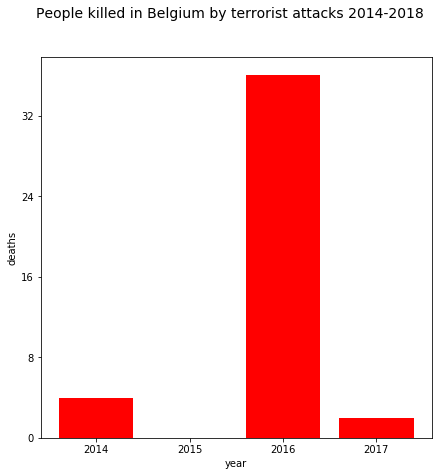

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
from datetime import datetime

y_axis = []
x_axis = []

for row in grouped_query.rdd.collect():
     #Toekennen aan x as
    x_axis.append(int(row.iyear))
    #Toekennen aan y as
    y_axis.append(int(row.nkill))
    
#Maken grafiek
fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('People killed in Belgium by terrorist attacks 2014-2018', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('year')
ax.set_ylabel('deaths')
ax.bar(x_axis, y_axis, fc='red', align='center')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

In [18]:
#Drop redundant data
df_passenger_data_brussels = df_passenger_data_brussels.drop('destination ICAO')

#Parse all data to int
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2004M03", df_passenger_data_brussels["2004M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2004M04", df_passenger_data_brussels["2004M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2005M03", df_passenger_data_brussels["2005M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2005M04", df_passenger_data_brussels["2005M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2006M03", df_passenger_data_brussels["2006M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2006M04", df_passenger_data_brussels["2006M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2007M03", df_passenger_data_brussels["2007M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2007M04", df_passenger_data_brussels["2007M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2008M03", df_passenger_data_brussels["2008M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2008M04", df_passenger_data_brussels["2008M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2009M03", df_passenger_data_brussels["2009M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2009M04", df_passenger_data_brussels["2009M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2010M03", df_passenger_data_brussels["2010M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2010M04", df_passenger_data_brussels["2010M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2011M03", df_passenger_data_brussels["2011M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2011M04", df_passenger_data_brussels["2011M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2012M03", df_passenger_data_brussels["2012M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2012M04", df_passenger_data_brussels["2012M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2013M03", df_passenger_data_brussels["2013M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2013M04", df_passenger_data_brussels["2013M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2014M03", df_passenger_data_brussels["2014M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2014M04", df_passenger_data_brussels["2014M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2015M03", df_passenger_data_brussels["2015M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2015M04", df_passenger_data_brussels["2015M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2016M03", df_passenger_data_brussels["2016M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2016M04", df_passenger_data_brussels["2016M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2017M03", df_passenger_data_brussels["2017M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2017M04", df_passenger_data_brussels["2017M04"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2018M03", df_passenger_data_brussels["2018M03"].cast(IntegerType()))
df_passenger_data_brussels = df_passenger_data_brussels.withColumn("2018M04", df_passenger_data_brussels["2018M04"].cast(IntegerType()))



In [19]:

from pyspark.sql import functions as F
#Summing up all data by year
df_passenger_data_2004 = df_passenger_data_brussels.groupBy().agg(F.sum('2004M03').alias("2004M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2004M04').alias("2004M04"))
df_passenger_data_2004 = df_passenger_data_2004.unionAll(df_passenger_data_1)
df_passenger_data_2004 = df_passenger_data_2004.groupBy().agg(F.sum('2004M03').alias("2004"))

df_passenger_data_2005 = df_passenger_data_brussels.groupBy().agg(F.sum('2005M03').alias("2005M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2005M04').alias("2005M04"))
df_passenger_data_2005.df_passenger_data_2005 = df_passenger_data_2005.unionAll(df_passenger_data_1)
df_passenger_data_2005 = df_passenger_data_2005.groupBy().agg(F.sum('2005M03').alias("2005"))

df_passenger_data_2006 = df_passenger_data_brussels.groupBy().agg(F.sum('2006M03').alias("2006M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2006M04').alias("2006M04"))
df_passenger_data_2006.df_passenger_data_2005 = df_passenger_data_2006.unionAll(df_passenger_data_1)
df_passenger_data_2006 = df_passenger_data_2006.groupBy().agg(F.sum('2006M03').alias("2006"))

df_passenger_data_2007 = df_passenger_data_brussels.groupBy().agg(F.sum('2007M03').alias("2007M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2007M04').alias("2007M04"))
df_passenger_data_2007.df_passenger_data_2005 = df_passenger_data_2007.unionAll(df_passenger_data_1)
df_passenger_data_2007 = df_passenger_data_2007.groupBy().agg(F.sum('2007M03').alias("2007"))

df_passenger_data_2008 = df_passenger_data_brussels.groupBy().agg(F.sum('2008M03').alias("2008M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2008M04').alias("2008M04"))
df_passenger_data_2008.df_passenger_data_2005 = df_passenger_data_2008.unionAll(df_passenger_data_1)
df_passenger_data_2008 = df_passenger_data_2008.groupBy().agg(F.sum('2008M03').alias("2008"))

df_passenger_data_2009 = df_passenger_data_brussels.groupBy().agg(F.sum('2009M03').alias("2009M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2009M04').alias("2009M04"))
df_passenger_data_2009.df_passenger_data_2005 = df_passenger_data_2009.unionAll(df_passenger_data_1)
df_passenger_data_2009 = df_passenger_data_2009.groupBy().agg(F.sum('2009M03').alias("2009"))

df_passenger_data_2010 = df_passenger_data_brussels.groupBy().agg(F.sum('2010M03').alias("2010M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2010M04').alias("2010M04"))
df_passenger_data_2010.df_passenger_data_2005 = df_passenger_data_2010.unionAll(df_passenger_data_1)
df_passenger_data_2010 = df_passenger_data_2010.groupBy().agg(F.sum('2010M03').alias("2010"))

df_passenger_data_2011 = df_passenger_data_brussels.groupBy().agg(F.sum('2011M03').alias("2011M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2011M04').alias("2011M04"))
df_passenger_data_2011.df_passenger_data_2005 = df_passenger_data_2011.unionAll(df_passenger_data_1)
df_passenger_data_2011 = df_passenger_data_2011.groupBy().agg(F.sum('2011M03').alias("2011"))

df_passenger_data_2012 = df_passenger_data_brussels.groupBy().agg(F.sum('2012M03').alias("2012M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2012M04').alias("2012M04"))
df_passenger_data_2012.df_passenger_data_2005 = df_passenger_data_2012.unionAll(df_passenger_data_1)
df_passenger_data_2012 = df_passenger_data_2012.groupBy().agg(F.sum('2012M03').alias("2012"))

df_passenger_data_2013 = df_passenger_data_brussels.groupBy().agg(F.sum('2013M03').alias("2013M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2013M04').alias("2013M04"))
df_passenger_data_2013.df_passenger_data_2005 = df_passenger_data_2013.unionAll(df_passenger_data_1)
df_passenger_data_2013 = df_passenger_data_2013.groupBy().agg(F.sum('2013M03').alias("2013"))

df_passenger_data_2014 = df_passenger_data_brussels.groupBy().agg(F.sum('2014M03').alias("2014M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2014M04').alias("2014M04"))
df_passenger_data_2014.df_passenger_data_2005 = df_passenger_data_2014.unionAll(df_passenger_data_1)
df_passenger_data_2014 = df_passenger_data_2014.groupBy().agg(F.sum('2014M03').alias("2014"))

df_passenger_data_2015 = df_passenger_data_brussels.groupBy().agg(F.sum('2015M03').alias("2015M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2015M04').alias("2015M04"))
df_passenger_data_2015.df_passenger_data_2005 = df_passenger_data_2015.unionAll(df_passenger_data_1)
df_passenger_data_2015 = df_passenger_data_2015.groupBy().agg(F.sum('2015M03').alias("2015"))

df_passenger_data_2016 = df_passenger_data_brussels.groupBy().agg(F.sum('2016M03').alias("2016M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2016M04').alias("2016M04"))
df_passenger_data_2016.df_passenger_data_2005 = df_passenger_data_2016.unionAll(df_passenger_data_1)
df_passenger_data_2016 = df_passenger_data_2016.groupBy().agg(F.sum('2016M03').alias("2016"))

df_passenger_data_2017 = df_passenger_data_brussels.groupBy().agg(F.sum('2017M03').alias("2017M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2017M04').alias("2017M04"))
df_passenger_data_2017.df_passenger_data_2005 = df_passenger_data_2017.unionAll(df_passenger_data_1)
df_passenger_data_2017 = df_passenger_data_2017.groupBy().agg(F.sum('2017M03').alias("2017"))

df_passenger_data_2018 = df_passenger_data_brussels.groupBy().agg(F.sum('2018M03').alias("2018M03"))
df_passenger_data_1 = df_passenger_data_brussels.groupBy().agg(F.sum('2018M04').alias("2018M04"))
df_passenger_data_2018.df_passenger_data_2005 = df_passenger_data_2018.unionAll(df_passenger_data_1)
df_passenger_data_2018 = df_passenger_data_2018.groupBy().agg(F.sum('2018M03').alias("2018"))

In [60]:
#Dataframe samenstellen met uiteindelijke data
field = [StructField('Years',IntegerType(), True),StructField('Passengers', IntegerType(), True)]

schema = StructType(field)
columns = ['Year', 'Passengers']
vals = [(df_passenger_data_2004.schema.names[0], df_passenger_data_2004.collect()[0][0]),
       (df_passenger_data_2005.schema.names[0], df_passenger_data_2005.collect()[0][0]),
       (df_passenger_data_2006.schema.names[0], df_passenger_data_2006.collect()[0][0]),
       (df_passenger_data_2007.schema.names[0], df_passenger_data_2007.collect()[0][0]),
       (df_passenger_data_2008.schema.names[0], df_passenger_data_2008.collect()[0][0]),
       (df_passenger_data_2009.schema.names[0], df_passenger_data_2009.collect()[0][0]),
       (df_passenger_data_2010.schema.names[0], df_passenger_data_2010.collect()[0][0]),
       (df_passenger_data_2011.schema.names[0], df_passenger_data_2011.collect()[0][0]),
       (df_passenger_data_2012.schema.names[0], df_passenger_data_2012.collect()[0][0]),
       (df_passenger_data_2013.schema.names[0], df_passenger_data_2013.collect()[0][0]),
       (df_passenger_data_2014.schema.names[0], df_passenger_data_2014.collect()[0][0]),
       (df_passenger_data_2015.schema.names[0], df_passenger_data_2015.collect()[0][0]),
       (df_passenger_data_2016.schema.names[0], df_passenger_data_2016.collect()[0][0]),
       (df_passenger_data_2017.schema.names[0], df_passenger_data_2017.collect()[0][0]),
       (df_passenger_data_2018.schema.names[0], df_passenger_data_2018.collect()[0][0])]

df_passengers_by_year = sqlContext.createDataFrame(vals, columns)

df_passengers_by_year.show()

+----+----------+
|Year|Passengers|
+----+----------+
|2004|    980458|
|2005|    472637|
|2006|    483522|
|2007|    503269|
|2008|    536988|
|2009|    469472|
|2010|    458935|
|2011|    501139|
|2012|    514781|
|2013|    528224|
|2014|    605136|
|2015|    640122|
|2016|    439874|
|2017|    685673|
|2018|    691397|
+----+----------+



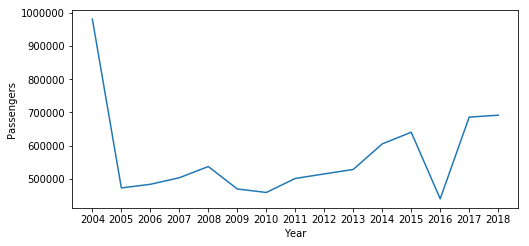

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
from datetime import datetime

y_axis = []
x_axis = []

for row in df_passengers_by_year.collect():
     #Toekennen aan x as
    x_axis.append(int(row.Year))
    #Toekennen aan y as
    y_axis.append(int(row.Passengers))
    
#Maken grafiek
#fig1 = plt.figure(figsize=(7, 7))
#fig1.suptitle('Passengers departing from airport Brussels 2004-2018', fontsize=14)
#ax = fig1.add_subplot(111)
#ax.set_xlabel('Year')
#ax.set_ylabel('Passengers')
#ax.bar(x_axis, y_axis, fc='red', align='center')
#ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.yaxis.set_major_locator(plt.MaxNLocator(5))

#plt.annotate('Terrorist attack', xy=(2016, 439874), xytext=(2014.42, 750000),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
#plt.show()

figl = plt.figure(figsize=(8,8))
fig1.suptitle('Passengers departing from airport Brussels 2004-2018', fontsize=14)
ax = figl.add_subplot(211)
ax.set_xlabel('Year')
ax.set_ylabel('Passengers')

plt.plot(df_passengers_by_year.select("Year").rdd.flatMap(lambda x: x).collect(), df_passengers_by_year.select("Passengers").rdd.flatMap(lambda x: x).collect())
plt.show()
df_passengers_by_year = df_passengers_by_year.join(grouped_query.withColumnRenamed("iyear", "Year"),on=['Year'],how='outer')


ValueError: setting an array element with a sequence.

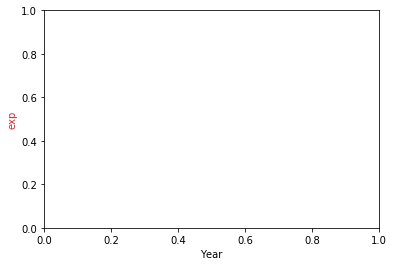

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(2004, 2005, 2006)
#data1 = np.exp(t)
#data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, df_passengers_by_year.select("nkill"), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, df_passengers_by_year.select("Passengers"), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



In [57]:
df_passengers_by_year.select("Year").collect()

[Row(Year='2016'),
 Row(Year='2012'),
 Row(Year='2017'),
 Row(Year='2014'),
 Row(Year='2013'),
 Row(Year='2005'),
 Row(Year='2009'),
 Row(Year='2018'),
 Row(Year='2006'),
 Row(Year='2004'),
 Row(Year='2011'),
 Row(Year='2008'),
 Row(Year='2007'),
 Row(Year='2015'),
 Row(Year='2010')]